### Initialization

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from os import path
import json
from ast import literal_eval
from public_MAPE import score_function
from time import time
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
from scipy.signal import butter, lfilter
width=15.0
height=7.5
plt.style.use("bmh")
matplotlib.rcParams['figure.figsize'] = (width, height)
all_colors = [parameter['color'] for parameter in plt.rcParams['axes.prop_cycle']]

### Load data

In [84]:
data_dir = "data"

train = pd.read_csv(path.join("CNN_pipeline", data_dir, "train_input.csv"), sep=';', index_col=0)
ages = pd.read_csv(path.join("CNN_pipeline", data_dir, "train_output.csv"), sep=';', index_col=0)

In [85]:
EEG = train.iloc[:, 1:-1]

### Constants

In [140]:
fs = 250.0 # sampling frequency
N = 75000 # number of points
T = 1.0/fs
n = int(20*fs) # 20 sec * fs
xtime = np.arange(n) / fs # time abcisses
xfreq = np.linspace(0.0, 1.0/(2.0*T), n//2+1) # freq abcisses
lowcut = 0.0 # the min freq desired
highcut = 100.0 # the max freq desired
bands = {"delta": (1.0, 4.0), "theta": (4.0, 8.0), "alpha": (8.0, 14.0), "beta": (14.0, 20.0)}

### Filtrer

In [87]:
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [88]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [89]:
def filter_signals(row, lowcut, highcut, fs, order=6):
    signal_filtered = butter_bandpass_filter(row, lowcut, highcut, fs, order=6)
    return signal_filtered

In [129]:
# either we filter or not
#EEG_filtered = EEG.apply(filter_signals, args=(lowcut, highcut, fs,), axis=1)
EEG_filtered = EEG

### Data augmentation

In [130]:
#n is the size of one subsample
def augmentData(x,y,n):
    (dudes, N) = x.shape
    x = x.values
    y = y.values
    newX = x.reshape((dudes*N//n, n))
    newY = np.repeat(y, N//n)
    return pd.DataFrame(newX), pd.DataFrame(newY)

In [131]:
EEG_filtered_aug, ages_aug = augmentData(EEG_filtered, ages, n)

### Periodogram

In [132]:
def get_periodogram(row, fs):
    n = len(row)//2
    periodo = np.zeros(2*n)
    data = row.values.astype("float64")
    f, Pxx_den = signal.periodogram(data, fs)
    periodo[:n+1] = Pxx_den
    return periodo

In [133]:
spectre = EEG_filtered_aug.apply(get_periodogram, args=(fs,), axis=1).iloc[:,:n//2+1]

In [134]:
lowind = int(lowcut*n/fs)
highind = int(highcut*n/fs)
spectre = spectre.iloc[:, lowind:highind+1] # we take only the freq between lowcut and highcut

### Binarization

In [135]:
size_bins = 5
min_ages = ages_aug.min()[0]
max_ages = ages_aug.max()[0]
spectre["BINS"] = size_bins*((ages_aug - min_ages) // size_bins) + min_ages
spectre["BINS"] = spectre["BINS"].replace(max_ages, max_ages-size_bins)

In [136]:
spectre_mean = spectre.groupby("BINS").mean()
spectre_std = spectre.groupby("BINS").std()
spectre_max = spectre_mean + spectre_std
spectre_min = spectre_mean - spectre_std

### Visualization

In [137]:
(low, high) = (4, 8)
lowband= int(low*n/fs)
highband = int(high*n/fs)

In [138]:
cmapB = matplotlib.cm.get_cmap('Blues')
cmapR = matplotlib.cm.get_cmap('Reds')

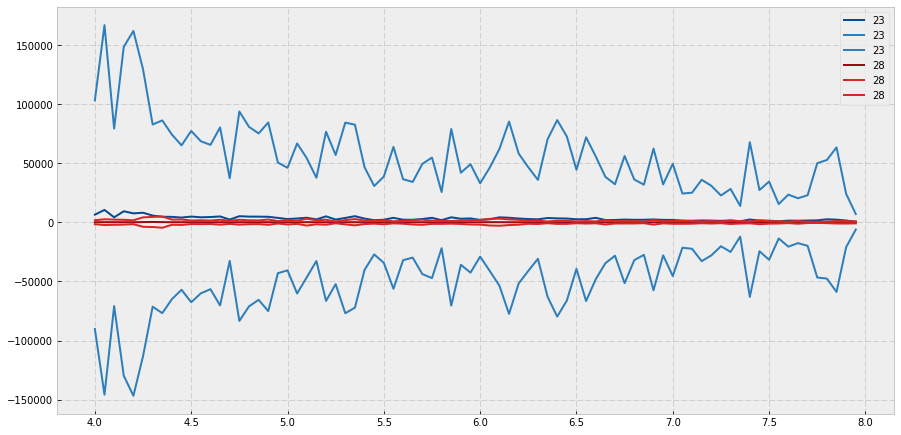

In [139]:
plt.plot(xfreq[lowband:highband], spectre_mean.iloc[1, lowband:highband], c=cmapB(0.9))
plt.plot(xfreq[lowband:highband], spectre_min.iloc[1, lowband:highband], c=cmapB(0.7))
plt.plot(xfreq[lowband:highband], spectre_max.iloc[1, lowband:highband], c=cmapB(0.7))
plt.plot(xfreq[lowband:highband], spectre_mean.iloc[2, lowband:highband], c=cmapR(0.9))
plt.plot(xfreq[lowband:highband], spectre_min.iloc[2, lowband:highband], c=cmapR(0.7))
plt.plot(xfreq[lowband:highband], spectre_max.iloc[2, lowband:highband], c=cmapR(0.7))
#plt.fill_between(xfreq[lowband:highband],
#                 spectre_min.iloc[1, lowband:highband],
#                 spectre_max.iloc[1, lowband:highband])
plt.legend()
#plt.savefig("theta_23-28ans_vs_33-38ans_noFilter.png")